In [1]:
import torch
import torchvision 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

C:\Users\KIIT\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

26422272it [00:14, 1834226.42it/s]                                                                                                                                         


Extracting data/FashionMNIST\raw\train-images-idx3-ubyte.gz to data/FashionMNIST\raw



29696it [00:00, 172965.07it/s]                                                                                                                                             


Extracting data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to data/FashionMNIST\raw



4422656it [00:03, 1379054.06it/s]                                                                                                                                          


Extracting data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data/FashionMNIST\raw



6144it [00:00, 6142980.64it/s]                                                                                                                                             


Extracting data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data/FashionMNIST\raw



In [3]:
len(dataset)

60000

In [4]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size=128

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
image,label=train_ds[101]

In [8]:
permuted_image=image.permute(1,2,0)
permuted_image.shape

torch.Size([28, 28, 1])

Bag


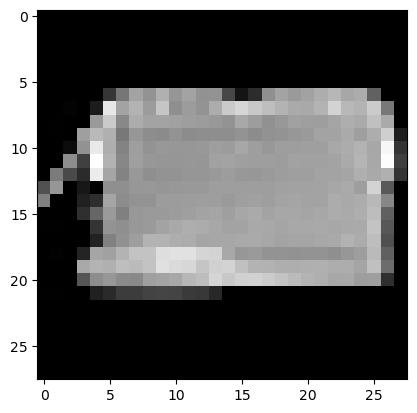

In [9]:
plt.imshow(image[0],cmap='gray');
print(class_names[label])

In [10]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])
8


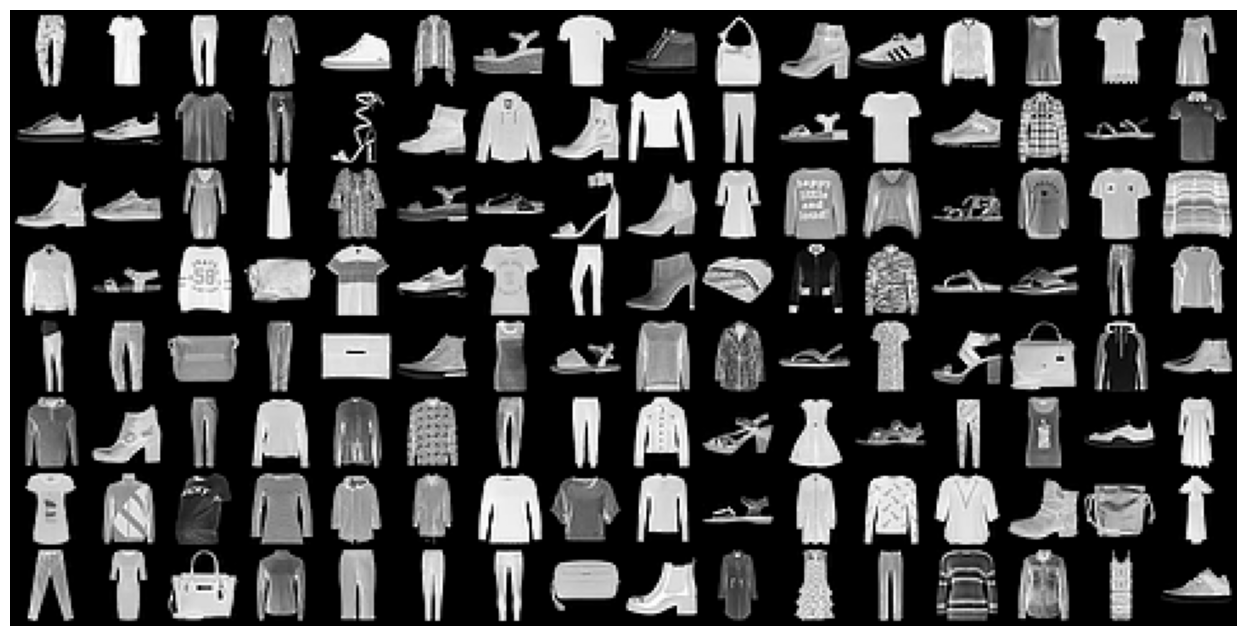

In [11]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    print(label)
    break

In [12]:
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [13]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 128)
        # hidden layer 2
        self.linear2 = nn.Linear(128, 32)
        # output layer
        self.linear3 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [14]:
torch.cuda.is_available()

False

In [30]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026A56A6C1F0>
Traceback (most recent call last):
  File "C:\Users\KIIT\anaconda3\envs\tf\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "C:\Users\KIIT\anaconda3\envs\tf\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Num GPUs Available:  0


In [15]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [16]:
device=get_default_device()
device

device(type='cpu')

In [17]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [18]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)
test_loader=DeviceDataLoader(test_loader,device)

Training the model

In [20]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
input_size=784
num_classes=10

In [22]:
model= MnistModel(input_size,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
history=[evaluate(model,val_loader)];
history

[{'val_loss': 2.3062264919281006, 'val_acc': 0.10107421875}]

In [24]:
history

[{'val_loss': 2.3062264919281006, 'val_acc': 0.10107421875}]

In [25]:
history+=fit(5,0.5,model,train_loader,val_loader)

KeyboardInterrupt: 

In [ ]:
history+=fit(5,0.5,model,train_loader,val_loader)

In [ ]:
history+=fit(5,0.5,model,train_loader,val_loader)

In [ ]:
history+=fit(5,0.5,model,train_loader,val_loader)

In [ ]:
losses=[x['val_loss'] for x in history]
plt.plot(losses,'-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('Loss vs no. of epochs');

In [ ]:
accuracy=[x['val_acc'] for x in history]
plt.plot(accuracy,'-x')
plt.xlabel('epoch')
plt.ylabel('val_acc')
plt.title('Accuracy vs no. of epochs');

**Prediction on Samples**

In [ ]:
def predict_image(img,model):
  xb=to_device(img.unsqueeze(0),device)
  yb=model(xb)
  _,pred=torch.max(F.softmax(yb,dim=1),dim=1)
  return pred[0].item()

In [ ]:
image,label=test_dataset[560]
plt.imshow(image[0],cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(image, model)])

In [ ]:
image,label=test_dataset[5600]
plt.imshow(image[0],cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(image, model)])

In [ ]:
image,label=test_dataset[1639]
plt.imshow(image[0],cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(image, model)])

In [ ]:
image,label=test_dataset[1049]
plt.imshow(image[0],cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(image, model)])

In [ ]:
image,label=test_dataset[2570]
plt.imshow(image[0],cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(image, model)])